#Imports

In [1]:
import pandas as pd
import pandana as pdna
from pandana.loaders import osm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import osmnx as ox
import os
import timeit

ox.settings.use_cache = True

ox.settings.log_console = True


#Save/load graphs

In [ ]:
start = timeit.timeit() #timing
#osmnx
filepath = "./data/copenhagen_network.graphml"
if(os.path.exists(filepath)):
    G = ox.io.load_graphml(filepath)
else:
    bbox = 12.4763, 55.5504, 12.6878, 55.7016
    G = ox.graph.graph_from_bbox(bbox, simplify = True, network_type="walk")  
    ox.io.save_graphml(G, filepath)

G = ox.project_graph(G)

#pandana
filepath_pan = "./data/copenhagen_features.h5"

if(os.path.exists(filepath_pan)):
    n, e = ox.graph_to_gdfs(G)
    e = e.reset_index()
    network = pdna.Network.from_hdf5(filepath_pan)
else:
    n, e = ox.graph_to_gdfs(G)
    e = e.reset_index()
    network = pdna.Network(n.geometry.x, n.geometry.y, e["u"], e["v"], e[["length"]])
    
    network.save_hdf5(filepath_pan)

places = ["Copenhagen Municipality, Denmark", "Frederiksberg Municipality, Denmark",]

pois = ox.features_from_place(
    places,
    tags={"amenity": "library"},
).to_crs(n.crs)

pois = pois.copy()
pois["geometry"] = pois.geometry.centroid

network.set_pois(
    category="library",
    maxdist=2000,
    maxitems=100,
    x_col=pois.geometry.x,
    y_col=pois.geometry.y,
)

dist = 1000

nearest_libraries = network.nearest_pois(
    distance=2000,
    category="library",
    num_pois=100,
)
n["nearest_libraries"] = (nearest_libraries <= dist).sum(axis=1)

C:\Users\Morte\miniconda3\envs\pan\lib\site-packages\geopandas\plotting.py:305: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


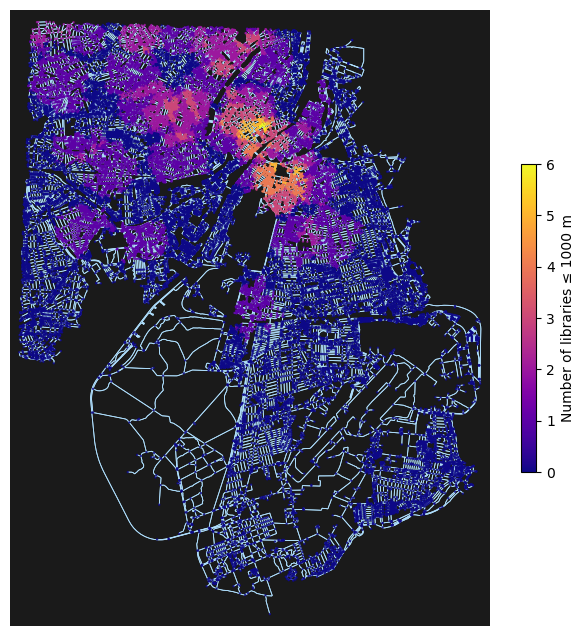

-0.010224100000414182


In [4]:
fig, ax = ox.plot.plot_graph(
    G,
    node_size=0,
    edge_color="#afdffe",
    edge_linewidth=0.6,
    bgcolor="#1a1a1a",
    show=False,
    close=False
)
"""
n.plot(
    ax=ax,
    column="nearest_libraries",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
) """

vmin = n["nearest_libraries"].min()
vmax = n["nearest_libraries"].max()

n.plot(
    ax=ax,
    column="nearest_libraries",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
    facecolor="white",
    legend_kwds={
        "shrink": 0.5,
        "label": f"Number of libraries ≤ {dist} m",
        "orientation": "vertical"
    },
    vmin=0,
    vmax=vmax
)

plt.show()
end = timeit.timeit()
print(end - start)
#135 sec
#v
#69 